In [1]:
import anndata as ad
import numpy as np
import scipy
import pandas as pd
import os

### Larry Data Loading and Preprocessing

In [2]:
# original snakemnake file
'''
rule differentiation_make_adata:
    input:
        normed_counts="resources/differentiation/GSM4185642_stateFate_inVitro_normed_counts.mtx.gz",
        gene_names="resources/differentiation/GSM4185642_stateFate_inVitro_gene_names.txt.gz",
        clone_matrix="resources/differentiation/GSM4185642_stateFate_inVitro_clone_matrix.mtx.gz",
        metadata="resources/differentiation/GSM4185642_stateFate_inVitro_metadata.txt.gz",
    output:
        d4d6_h5ad="results/single_cell_differentiation/data/d4_d6_differentiation.h5ad",
        d2_h5ad="results/single_cell_differentiation/data/d2_differentiation.h5ad",
    conda:
        "../envs/TACCO_env.yml"
    resources:
        mem_mb=8000
    log:
        "logs/single_cell_differentiation/differentiation_make_adata.log"
    benchmark:
        "benchmarks/single_cell_differentiation/differentiation_make_adata.tsv"
    script:
        "differentiation_make_adata.py"
'''

'\nrule differentiation_make_adata:\n    input:\n        normed_counts="resources/differentiation/GSM4185642_stateFate_inVitro_normed_counts.mtx.gz",\n        gene_names="resources/differentiation/GSM4185642_stateFate_inVitro_gene_names.txt.gz",\n        clone_matrix="resources/differentiation/GSM4185642_stateFate_inVitro_clone_matrix.mtx.gz",\n        metadata="resources/differentiation/GSM4185642_stateFate_inVitro_metadata.txt.gz",\n    output:\n        d4d6_h5ad="results/single_cell_differentiation/data/d4_d6_differentiation.h5ad",\n        d2_h5ad="results/single_cell_differentiation/data/d2_differentiation.h5ad",\n    conda:\n        "../envs/TACCO_env.yml"\n    resources:\n        mem_mb=8000\n    log:\n        "logs/single_cell_differentiation/differentiation_make_adata.log"\n    benchmark:\n        "benchmarks/single_cell_differentiation/differentiation_make_adata.tsv"\n    script:\n        "differentiation_make_adata.py"\n'

This normalized count matrix reports the number of transcripts (UMIs) for each gene in each cell, after total-counts normalization (i.e. L1 normalization on cells). Rows represent cells and columns represent genes. There are no column or row labels. Gene names and cell metadata are provided in separate files.

In [3]:
normed_counts = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_normed_counts.mtx.gz"  #snakemake.input['normed_counts']
gene_names = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_gene_names.txt.gz" #snakemake.input['gene_names']
clone_matrix = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_clone_matrix.mtx.gz" #snakemake.input['clone_matrix']
metadata = "/Users/apple/Desktop/KB/Dataset1/stateFate_inVitro_metadata.txt.gz" #snakemake.input['metadata']

output_d4d6_h5ad = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/Larry_test/tacco_output/d4d6_h5ad" #snakemake.output['d4d6_h5ad']
output_d2_h5ad = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/Larry_test/tacco_output/d2_h5ad" #snakemake.output['d2_h5ad']

In [4]:
# load data
normed_counts_mat = scipy.io.mmread(normed_counts).tocsr()
genes = pd.read_csv(gene_names, sep='\t',header=None).to_numpy().flatten()
clone_mat = scipy.io.mmread(clone_matrix).tocsr()
meta_df = pd.read_csv(metadata, sep='\t')

In [5]:
meta_df.head()

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y
0,d6_2_2,GCGTGCAA-AGAAGTTA,6.0,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190
1,d6_2_2,AAGGGACC-CTCGATGC,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925
2,d6_2_2,CGTACCGA-AGCGCCTT,6.0,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300
3,d6_2_2,CTGAAGGG-AGGAGCTT,6.0,Lin-Kit+Sca1-,Neutrophil,2,1150.028,-2030.369
4,d6_2_2,CCGTAGCT-AGGCAGTT,6.0,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010


In [6]:
# create full adata
adata = ad.AnnData(normed_counts_mat, obs=meta_df, var=pd.DataFrame(index=genes), dtype=np.float32)

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata.X

<130887x25289 sparse matrix of type '<class 'numpy.float32'>'
	with 176867560 stored elements in Compressed Sparse Row format>

In [8]:
# optimize dtypes
adata.obs['Library'] = adata.obs['Library'].astype('category')
adata.obs['Time point'] = adata.obs['Time point'].astype(int)
adata.obs['Starting population'] = adata.obs['Starting population'].astype('category')
adata.obs['Cell type annotation'] = adata.obs['Cell type annotation'].astype('category')
adata.obs['Well'] = adata.obs['Well'].astype(int)
# assign clone_id
adata.obs['clone_id'] = (clone_mat @ np.arange(1,1+clone_mat.shape[1])) - 1

In [9]:
adata.obs.shape

(130887, 9)

In [10]:
# assign clone_id
adata.obs['clone_id'] = (clone_mat @ np.arange(1,1+clone_mat.shape[1])) - 1

In [11]:
# subset to clones appearing in day 2 and in day 4 or 6
time_dummies = pd.get_dummies(adata.obs['Time point'])
clone_in_day = pd.DataFrame(clone_mat.T @ time_dummies,columns=time_dummies.columns).astype(bool)  # 5863*3 mat indicates days when this multi-cell clone appears
everywhere_clones = clone_in_day[2] & (clone_in_day[4] | clone_in_day[6])
everywhere_clone_ids = everywhere_clones[everywhere_clones].index
adata_everywhere = adata[adata.obs['clone_id'].isin(everywhere_clone_ids)] #take a subset (17638 cells were selected) -> only those cells that belong to the clone which appear in day 2 and day4 or 6.

In [12]:
adata_everywhere.obs

,Library,Cell barcode,Time point,Starting population,Cell type annotation,Well,SPRING-x,SPRING-y,clone_id
14,d6_2_2,AGGGACTG-ATATACCT,6,Lin-Kit+Sca1-,Undifferentiated,2,554.803,-285.021,1110
15,d6_2_2,AGACGAGG-GTCTCTCT,6,Lin-Kit+Sca1-,Neutrophil,2,575.826,-1089.986,3529
16,d6_2_2,GTCAGACC-AAGATTGT,6,Lin-Kit+Sca1-,Undifferentiated,2,603.763,-643.997,5725
26,d6_2_2,ATGACTTG-AGACACCA,6,Lin-Kit+Sca1-,Undifferentiated,2,7.604,20.722,1041
34,d6_2_2,GGTTGAGA-GAGCCCAT,6,Lin-Kit+Sca1-,Undifferentiated,2,2258.214,-1837.046,3339
...,...,...,...,...,...,...,...,...,...
130817,LSK_d6_1_3,GAATCCCA-AGCAGAAC,6,Lin-Kit+Sca1+,Monocyte,1,2522.559,-176.379,1149
130846,LSK_d6_1_3,ATGGTCTG-GTTACCGC,6,Lin-Kit+Sca1+,Baso,1,-840.720,-755.382,4505
130850,LSK_d6_1_3,AATATGAC-GTCCAAAG,6,Lin-Kit+Sca1+,Undifferentiated,1,133.389,282.840,2774
130863,LSK_d6_1_3,AGTTTGTA-TGTCTTTC,6,Lin-Kit+Sca1+,Undifferentiated,1,-711.945,440.552,2838


In [13]:
# split into reference (day 4 and 6) and test (day 2) data
day4_day6 = adata_everywhere.obs['Time point']>2
adata_46 = adata_everywhere[day4_day6].copy()
adata_2 = adata_everywhere[~day4_day6].copy()

In [14]:
# determine clone fate (ground truth) for the test data from the differentiated data
clone_fate = adata_46.obs[['Cell type annotation', 'clone_id']].value_counts().unstack().fillna(0).T
adata_2.obsm['clone_fate'] = clone_fate.loc[adata_2.obs['clone_id']].set_index(adata_2.obs.index)
adata_2.obsm['clone_fate'] /= adata_2.obsm['clone_fate'].sum(axis=1).to_numpy()[:,None] #add up all the cell counts by row and then scale the cell counts by this number

In [15]:
clone_fate.loc[adata_2.obs['clone_id']].set_index(adata_2.obs.index)

Cell type annotation,Baso,Ccr7_DC,Eos,Erythroid,Lymphoid,Mast,Meg,Monocyte,Neutrophil,Undifferentiated,pDC
13199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,6.0,0.0
13210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
13226,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69313,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
69317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0
69322,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,10.0,0.0
69324,41.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
# use only "final" fates, i.e. all except 'Undifferentiated'
types = ['Neutrophil','Erythroid','Monocyte','Meg','Mast','Baso','Lymphoid','Eos','Ccr7_DC','pDC']
d4d6 = adata_46[adata_46.obs['Cell type annotation'].isin(types)]
d2 = adata_2[adata_2.obsm['clone_fate'][types].sum(axis=1) == 1]
d2.obsm['clone_fate'] = d2.obsm['clone_fate'][types]

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_7414/95401042.py:5: ImplicitModificationWarning: Setting element `.obsm['clone_fate']` of view, initializing view as actual.
  d2.obsm['clone_fate'] = d2.obsm['clone_fate'][types]


### Scvi implementation

In [17]:
import tempfile

import scanpy as sc
import scvi
import torch

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [18]:
## Imports for plottig
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_7414/3240655875.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


<Figure size 640x480 with 0 Axes>

In [19]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [23]:
sc.set_figure_params(figsize=(8, 8))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

we didn't remove any gene (using `sc.pp.filter_genes(adata, min_counts=3)`), since the counts are normalized.

In [21]:
adata.layers['counts'] = adata.X.copy()
adata.layers

Layers with keys: counts

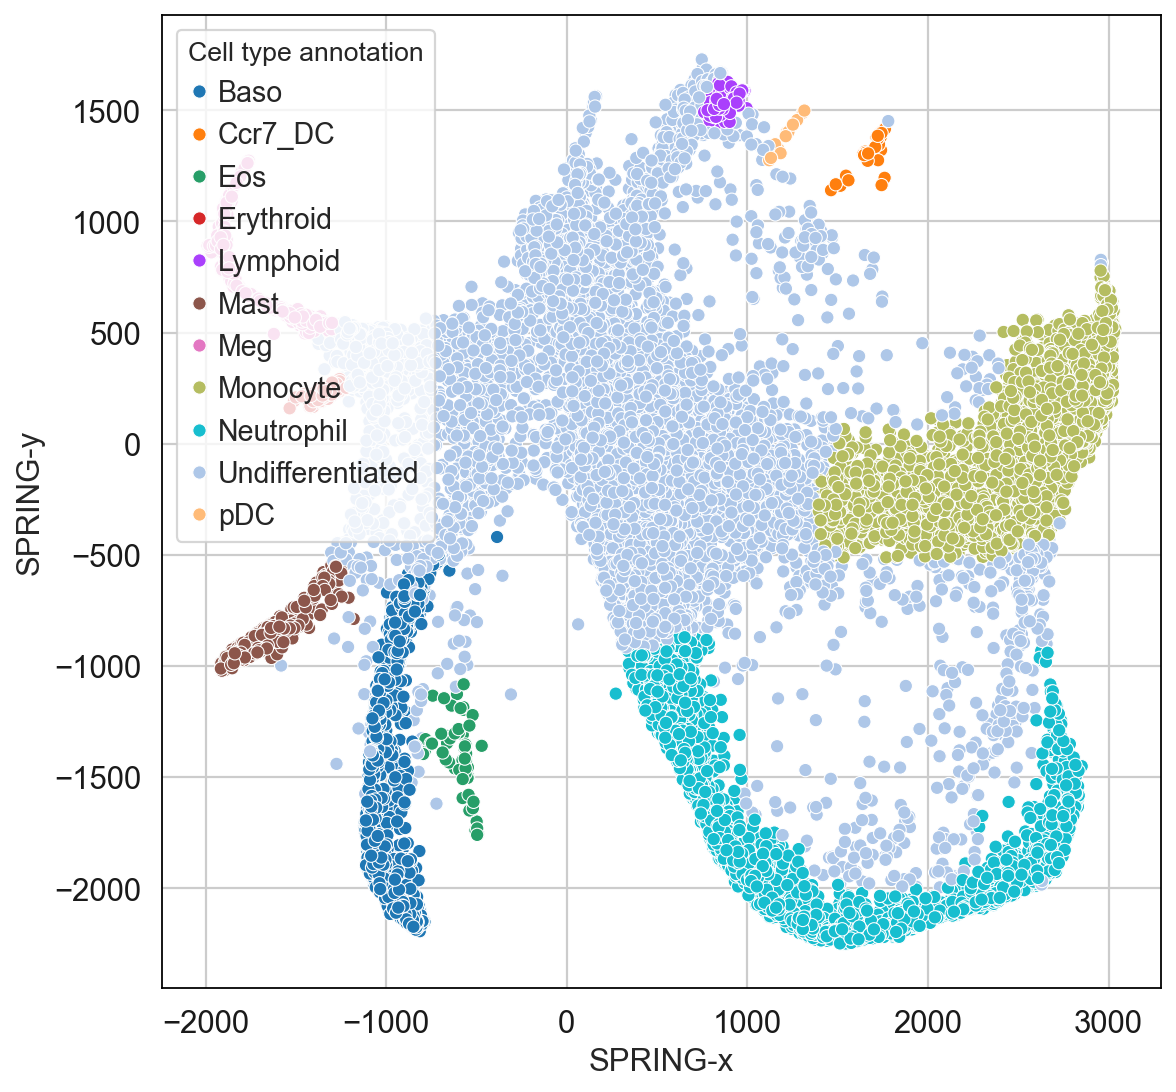

In [24]:
sns.scatterplot(data=adata_everywhere.obs, x='SPRING-x', y='SPRING-y', hue='Cell type annotation')
plt.show()